# <오늘 할 것: Augmentation, PreTrained CNN>

# 1. 개/고양이 분류 예제
- 1-1. Augmentation 없이
- 1-2. Augmentation 적용
- 1-3. 모델 저장 및 복구

# 2. 과일 분류 예제
- 2-1. Augmentation
- 2-2. 모델 생성 및 학습
- 2-3. 모델 테스트

# 3. Imagenet

# 4. Pretrained CNN
- 4-1. Vgg
- 4-2. 다른 모델
    - 4-2-1. ResNet
    - 4-2-2. Inception
    - 4-2-3. MobileNet
- 4-3. 모델별 결과 시각화
- 4-4. 다시 해보기: include_top = False

# 5. 일반화
- 5-1. 직접 해보기
    - 5-1-1. 주의사항
- 5-2. 솔루션

# 6. 전이학습(과일예제)
- 6-1. 전체 freezing
    - 6-1-1. w/o Augmentation
    - 6-1-2. w/ Augmentation
- 6-2. Pretrained CNN 몇 레이어 살리기
    - 6-2-1. w/ Augmentation
    
## 부록) 정규화의 중요성

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras
import tensorflow as tf
import numpy as np
from numpy  import expand_dims
import cv2
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
np.random.seed(15)

Using TensorFlow backend.


# 1. 개/고양이 분류 예제

## 1-1. Augmentation 없이

In [12]:
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255 )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지를 배치 단위로 불러와 줄 generator입니다.
train_generator = train_datagen.flow_from_directory(
        'smallcatdog/train',  # this is the target directory
        target_size=(150, 150),  # 모든 이미지의 크기가 150x150로 조정됩니다.
        batch_size=batch_size,
        class_mode='binary')  # binary_crossentropy 손실 함수를 사용하므로 binary 형태로 라벨을 불러와야 합니다.

validation_generator = validation_datagen.flow_from_directory(
        'smallcatdog/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        'smallcatdog/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50, # 50
        validation_data=validation_generator,
        validation_steps=800 // batch_size)

#모델 저장
model.save("smallcatdog_wa.h5")
scores = model.evaluate_generator( test_generator,       steps = 800 // 16)
print(scores[1])

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50
125/125 [==============================] - 18s 148ms/step - loss: 0.7067 - accuracy: 0.5350 - val_loss: 0.8912 - val_accuracy: 0.5312
Epoch 2/50
125/125 [==============================] - 19s 154ms/step - loss: 0.6527 - accuracy: 0.6240 - val_loss: 0.6261 - val_accuracy: 0.6025
Epoch 3/50
125/125 [==============================] - 18s 140ms/step - loss: 0.5955 - accuracy: 0.6940 - val_loss: 0.4060 - val_accuracy: 0.6963
Epoch 4/50
125/125 [==============================] - 18s 140ms/step - loss: 0.5382 - accuracy: 0.7335 - val_loss: 0.5506 - val_accuracy: 0.6875
Epoch 5/50
125/125 [==============================] - 18s 146ms/step - loss: 0.5050 - accuracy: 0.7710 - val_loss: 0.4165 - val_accuracy: 0.7138
Epoch 6/50
125/125 [==============================] - 18s 145ms/step - loss: 0.4581 - accuracy: 0.7880 - val_loss: 0.4585 - val_accuracy: 0.7275
Epoch 

## 1-2. Augmentation 적용

In [13]:
batch_size = 16

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# 검증 및 테스트 이미지는 augmentation을 적용하지 않음(이미지 원본을 사용)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지를 배치 단위로 불러와 줄 generator입니다.
train_generator = train_datagen.flow_from_directory(
        './smallcatdog/train', 
        target_size=(150, 150), 
        batch_size=batch_size,
        class_mode='binary') 

validation_generator = validation_datagen.flow_from_directory(
        './smallcatdog/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        './smallcatdog/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


예전에는 학습시킬 대상만 있는 그레이 영상만을 사용했다.

최근 딥러닝에서는 다른 요소들도 포함된 컬러 영상을 사용한다.

배경이 많이 들어가서 고양이가 작은 이미지가 다수 존재하기 때문에 Maxpooling을 모든 convolution layer에서 수행해준다.

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))    

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_21 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_22 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 64)       

steps_per_epoch는 보통 (전체 데이터 셋 / batch_size)로 지정해준다.
- steps는 next 함수를 호출하는 횟수
- 한 번에 한 batch씩 돌아가기 때문에 전체를 batch_size로 나누어주면 모든 데이터를 한번씩 돌릴 수 있는 것.

In [16]:
# steps_per_epoch는 한 세대마다 몇 번 생성기로부터 데이터를 얻을지를 나타내는 값
# 한 세대마다 사용되는 학습데이터의 수는 steps_per_epoch * batch_size
        
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,    # 2000/16     한번에 125개씩 생성
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)     # 800/16   한번에 50개씩 생성

#모델 저장
model.save("smallcatdog.h5")

# 모델 평가하기
print("-- Evaluate --")
scores = model.evaluate_generator( test_generator, steps = 800 / 16)
print(scores[1])

Epoch 1/50
125/125 [==============================] - 19s 151ms/step - loss: 0.7196 - accuracy: 0.4815 - val_loss: 0.6946 - val_accuracy: 0.5962
Epoch 2/50
125/125 [==============================] - 18s 144ms/step - loss: 0.6857 - accuracy: 0.5605 - val_loss: 0.5583 - val_accuracy: 0.6025
Epoch 3/50
125/125 [==============================] - 18s 148ms/step - loss: 0.6544 - accuracy: 0.6415 - val_loss: 0.6715 - val_accuracy: 0.5987
Epoch 4/50
125/125 [==============================] - 20s 157ms/step - loss: 0.6302 - accuracy: 0.6530 - val_loss: 0.5123 - val_accuracy: 0.6263
Epoch 5/50
125/125 [==============================] - 20s 157ms/step - loss: 0.6233 - accuracy: 0.6705 - val_loss: 0.5291 - val_accuracy: 0.6975
Epoch 6/50
125/125 [==============================] - 20s 159ms/step - loss: 0.6142 - accuracy: 0.6895 - val_loss: 0.8012 - val_accuracy: 0.6725
Epoch 7/50
125/125 [==============================] - 19s 148ms/step - loss: 0.5811 - accuracy: 0.7080 - val_loss: 0.7086 - val_ac

마찬가지로 steps는 (전체 데이터 셋 / batch_size)로 지정한다.

Augmentation 적용하니 정확도가 10퍼센트포인트 정도 개선되었다.

## 1-3. 모델 저장 및 복구

- `save` 메소드로 모델을 저장
    - 확장자는 
    h5

(커널 리스타트)

- `load_model` 메소드로 모델을 복구

In [3]:
from keras.models import load_model
model = load_model('smallcatdog.h5')

In [4]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_21 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_22 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 64)       

In [5]:
#불러온 모델 평가: 평가를 위해 필요한 부분들만 다시 정의해준다.
batch_size = 16 
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'smallcatdog/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

#평가
scores = model.evaluate_generator(test_generator, steps = 800 // 16)
print(scores[1])

Found 800 images belonging to 2 classes.
0.7837499976158142


# 2. 과일 분류 예제

## 2-1. Augmentation

In [8]:
batch_size = 15

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# 검증 및 테스트 이미지는 augmentation을 적용하지 않음(이미지 원본을 사용)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지를 배치 단위로 불러와 줄 generator입니다.
train_generator = train_datagen.flow_from_directory(
        './clean-dataset/train', 
        target_size=(150, 150), 
        batch_size=batch_size,
        class_mode='categorical') 

validation_generator = validation_datagen.flow_from_directory(
        './clean-dataset/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        './clean-dataset/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


## 2-2. 모델 생성 및 학습

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit_generator(
        train_generator,
        steps_per_epoch= 600 // batch_size,
        epochs=50, # 50
        validation_data=validation_generator,
        validation_steps= 150 // batch_size)

#모델 저장
model.save("fruits.h5")
scores = model.evaluate_generator( test_generator,       steps = 150 // batch_size)
print(scores[1])

Epoch 1/50
40/40 [==============================] - 7s 171ms/step - loss: 0.8374 - accuracy: 0.6300 - val_loss: 0.2909 - val_accuracy: 0.8000
Epoch 2/50
40/40 [==============================] - 5s 130ms/step - loss: 0.5818 - accuracy: 0.7767 - val_loss: 0.3858 - val_accuracy: 0.7800
Epoch 3/50
40/40 [==============================] - 5s 129ms/step - loss: 0.4503 - accuracy: 0.8200 - val_loss: 0.8719 - val_accuracy: 0.8000
Epoch 4/50
40/40 [==============================] - 5s 132ms/step - loss: 0.4227 - accuracy: 0.8450 - val_loss: 0.2347 - val_accuracy: 0.8267
Epoch 5/50
40/40 [==============================] - 5s 129ms/step - loss: 0.4152 - accuracy: 0.8517 - val_loss: 0.2505 - val_accuracy: 0.8600
Epoch 6/50
40/40 [==============================] - 5s 129ms/step - loss: 0.3727 - accuracy: 0.8617 - val_loss: 0.5180 - val_accuracy: 0.8667
Epoch 7/50
40/40 [==============================] - 5s 131ms/step - loss: 0.4133 - accuracy: 0.8283 - val_loss: 0.3779 - val_accuracy: 0.8533
Epoch 

In [12]:
scores = model.evaluate_generator(test_generator, steps = 150// batch_size)
print(scores[1])

0.9266666769981384


## 2-3. 모델 테스트

In [31]:
# 모델 예측하기
print("-- Predict --")
output = model.predict_generator(test_generator) 

T = test_generator.classes    #classes 메소드를 활용하면 바로 테스트 데이터 라벨을 확인할 수 있다.
print(T)
p = np.argmax(output, axis=1)
print(p)

sum((p == T)*1) / len(p)

-- Predict --
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[1 2 1 0 2 2 2 2 1 0 0 0 2 0 1 1 1 0 2 2 0 0 2 1 1 0 1 0 2 1 1 1 2 0 0 0 0
 1 0 2 0 1 2 1 2 1 0 0 1 1 2 2 2 0 0 2 0 1 1 2 1 2 1 0 0 2 2 0 2 0 2 1 0 0
 1 0 2 0 2 0 0 2 2 2 1 0 1 2 1 0 2 2 1 1 1 0 1 2 2 0 1 1 0 0 2 0 2 2 1 0 1
 0 0 1 0 0 0 1 2 1 0 1 1 1 0 2 0 1 2 0 0 1 1 2 1 2 0 2 1 0 0 0 0 0 2 0 2 2
 2 2]


0.3

accuracy가 다르게 나온다.

이거 왜 이럴까?

# 3. Imagenet

In [7]:
from bs4 import BeautifulSoup
import numpy as np
import requests
import cv2
import PIL.Image
import urllib

In [8]:
page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n04194289") #ship synset  wnetid
soup = BeautifulSoup(page.content, 'html.parser')
str_soup=str(soup)
split_urls=str_soup.split('\r\n')
print(len(split_urls))

1262


In [9]:
bikes_page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n02834778")#bicycle synset
bikes_soup = BeautifulSoup(bikes_page.content, 'html.parser')
bikes_str_soup=str(bikes_soup)
bikes_split_urls=bikes_str_soup.split('\r\n')
print(len(bikes_split_urls))

1345


In [6]:
def url_downalod(urls, path, prefix) :    
    idx = 0
    for url in urls :
        try:
            resp = urllib.request.urlopen(url)
            image = np.asarray(bytearray(resp.read()), dtype="uint8")
            image = cv2.imdecode(image, cv2.IMREAD_COLOR)
            if ( len(image.shape)) == 3 :
                print(url)
                idx += 1
                save_path = path + '/' + prefix + str(idx)+'.jpg'
                cv2.imwrite(save_path,image)
        except :
            None


In [10]:
url_downalod(split_urls, 'imagenet/ship', 'ship') # aa 폴더에 ship1 부터 저장

http://static.flickr.com/85/233578996_8f74463083.jpg
http://farm2.static.flickr.com/1019/534041866_3aa182311c.jpg
http://static.flickr.com/88/231940102_7beb5ecf3e.jpg
http://farm4.static.flickr.com/3138/2724596903_d74dd64821.jpg
http://static.flickr.com/174/453920264_9406e9972c.jpg
http://farm1.static.flickr.com/147/423542865_c091691a6b.jpg
http://farm3.static.flickr.com/2269/2348294071_94fc609f4a.jpg
http://static.flickr.com/1016/1443997081_b5eb875055.jpg
http://www.fondear.org/infonautic/Barco/Barco_Navegando/Contenedores_Peligro/sea_container_ship2.jpg
http://static.flickr.com/198/491737075_0100196a8f.jpg
http://farm4.static.flickr.com/3132/2640561254_b114ac2788.jpg
http://farm1.static.flickr.com/12/14188200_7c98ba44cc.jpg
http://farm4.static.flickr.com/3226/2350689291_dbcebb71ee.jpg
http://farm4.static.flickr.com/3282/2576278846_63f669f036.jpg
http://farm4.static.flickr.com/3171/2640549706_a942ef34dc.jpg
http://farm4.static.flickr.com/3174/2596564567_44576822ca.jpg
http://farm2.sta

http://farm4.static.flickr.com/3260/2492729079_2aed94514b.jpg
http://farm4.static.flickr.com/3049/2602123185_254749735f.jpg
http://farm2.static.flickr.com/1322/1448111159_6697cad2a8.jpg
http://farm3.static.flickr.com/2234/2167268318_f97cd11159.jpg
http://farm3.static.flickr.com/2340/2478837754_bd1ff13944.jpg
http://static.flickr.com/87/231698153_b3e27fc211.jpg
http://farm3.static.flickr.com/2035/2359142241_1374c4cab1.jpg
http://farm1.static.flickr.com/46/145308544_5bfb02f5ac.jpg
http://farm3.static.flickr.com/2382/2444440896_e7b1877c3d.jpg
http://farm4.static.flickr.com/3247/2600672325_defc777e1c.jpg
http://farm1.static.flickr.com/252/453920158_06432cbf6c.jpg
http://farm3.static.flickr.com/2190/2493576070_cb14aec71c.jpg
http://farm4.static.flickr.com/3289/2675229236_b5b92e8cab.jpg
http://farm2.static.flickr.com/1150/1350872014_8ed8e8d0de.jpg
http://farm4.static.flickr.com/3253/2732608587_e86002f169.jpg
http://farm4.static.flickr.com/3290/2521011534_fd41f4c824.jpg
http://farm4.static.fl

http://farm4.static.flickr.com/3171/2352879683_c38e45ab6e.jpg
http://farm1.static.flickr.com/184/382955436_d8d62477d3.jpg
http://static.flickr.com/43/121335594_538788d9dc.jpg
http://www.saratogamuseum.org/images/cv-60a2.jpg
http://farm4.static.flickr.com/3039/2640494356_afd6568662.jpg
http://static.flickr.com/98/232539594_03cf11f02f.jpg
http://bridgehands.com/Reviews/Bridge_Cruises/Queen_Elizabeth_II.jpg
http://farm1.static.flickr.com/119/306516984_b712a20ff9.jpg
http://farm1.static.flickr.com/169/445326229_ba409b1f28.jpg
http://farm1.static.flickr.com/47/138502952_cdf0c6262d.jpg
http://farm1.static.flickr.com/39/118622081_b6c0b9ef55.jpg
http://farm1.static.flickr.com/168/437999446_38281c84a0.jpg
http://static.flickr.com/2368/2077116703_be08dcc33b.jpg
http://farm1.static.flickr.com/161/423543687_edfda8acc2.jpg
http://www.vos.noaa.gov/MWL/aug_06/Images/shipwreck.jpg
http://static.flickr.com/2118/2041510746_3a83386b31.jpg
http://www.soest.hawaii.edu/SOEST_News/PressReleases/AGU2003/KM%20

http://farm3.static.flickr.com/2349/2370921915_ddac030406.jpg
http://farm1.static.flickr.com/44/138502844_764fffd900.jpg
http://static.flickr.com/201/524458663_2721a72508.jpg
http://lh3.ggpht.com/_Z4TXFpxoEuU/SGnGvSQsB9I/AAAAAAAAAg0/FzKjUPdPJKw/IMG_6486.JPG
http://farm1.static.flickr.com/237/515550861_39a7a544e8.jpg
http://farm2.static.flickr.com/1153/1342047740_b8639a8c96.jpg
http://farm3.static.flickr.com/2035/2525264755_e9d6194b64.jpg
http://farm1.static.flickr.com/42/120051826_c6cd0bfc42.jpg
http://farm1.static.flickr.com/158/423544592_ccdc979eea.jpg
http://farm1.static.flickr.com/187/468322192_7e4cb119c2.jpg
http://farm1.static.flickr.com/6/5764846_45024d12f6.jpg
http://static.flickr.com/51/137124335_7407a6eca9.jpg
http://www.spacewar.com/images/littoral-combat-ship-freedom-lcs1-bg.jpg
http://farm1.static.flickr.com/165/423543550_51be0c8682.jpg
http://farm3.static.flickr.com/2208/2237664545_d420eaa0b9.jpg
http://farm1.static.flickr.com/139/345479194_6ceee30c16.jpg
http://lh3.ggpht

http://farm4.static.flickr.com/3128/2629807199_9c90a94741.jpg
http://www.stockphotography.co.uk/Upload/Stock/Watermarked/20274.jpg
http://static.flickr.com/2207/1842172673_d97f75e51f.jpg
http://static.flickr.com/95/242913660_512de1c1e3.jpg
http://farm3.static.flickr.com/2244/2483801176_9fc734c0a4.jpg
http://farm1.static.flickr.com/53/120055267_71dd255748.jpg
http://farm3.static.flickr.com/2290/2239345415_4b74c3b32a.jpg
http://static.flickr.com/1197/546233189_8388aa5abb.jpg
http://farm1.static.flickr.com/55/138503050_db61c70a7c.jpg?v=0
http://farm3.static.flickr.com/2122/2004729557_5cf7bbc74d.jpg
http://farm3.static.flickr.com/2037/2387756759_4dc3a945db.jpg
http://farm1.static.flickr.com/24/58989336_b2ea6ca077.jpg
http://www.cnn.com/WORLD/Newsbriefs/9601/01-11/freighter.rtv.jpg
http://farm4.static.flickr.com/3037/2582711281_c35d9df4c8.jpg
http://static.flickr.com/2357/2084338770_d4400c36e2.jpg
http://farm3.static.flickr.com/2202/1810841698_bb7029a5e8.jpg
http://farm2.static.flickr.com/1

http://farm1.static.flickr.com/92/268474470_72917cac50.jpg
http://farm2.static.flickr.com/1179/908281823_c4f1a39650.jpg
http://farm1.static.flickr.com/190/524458575_d46e01af74.jpg
http://farm2.static.flickr.com/1346/1219656987_71e3335c69.jpg
http://farm2.static.flickr.com/1323/917279812_e42f5a2274.jpg
http://farm4.static.flickr.com/3204/2336857699_5461510a13.jpg
http://farm1.static.flickr.com/77/179386849_ff962e74cb.jpg
http://farm4.static.flickr.com/3080/2475656774_462cdb0c15.jpg
http://farm1.static.flickr.com/69/188303507_d2bebd99ae.jpg
http://farm2.static.flickr.com/1414/908769474_5396ca081a.jpg
http://farm1.static.flickr.com/54/145308539_b8d3f67af7.jpg
http://farm2.static.flickr.com/1112/529734115_c29d2de053.jpg
http://farm3.static.flickr.com/2258/2097608924_1890988861.jpg
http://farm2.static.flickr.com/1145/908975482_c445b5946c.jpg
http://sanctuaries.noaa.gov/sse/education/summits/Images/SBmimi.jpeg
http://farm2.static.flickr.com/1107/1425397193_4627146a56.jpg
http://farm2.static.

In [11]:
url_downalod(bikes_split_urls, 'imagenet/bikes', 'bike')

http://farm2.static.flickr.com/1090/1441125154_341230126c.jpg
http://farm4.static.flickr.com/3219/2681908945_dbe4c38deb.jpg
http://farm3.static.flickr.com/2186/2358375851_fa98bf5314.jpg
http://farm3.static.flickr.com/2375/2463989860_28a9d6743c.jpg
http://upload.wikimedia.org/wikipedia/commons/a/a1/A_Bicycle_in_Oxford.JPG
http://farm1.static.flickr.com/220/503379999_8301b3ed00.jpg
http://farm1.static.flickr.com/21/26188741_0a4a18d992.jpg
http://farm3.static.flickr.com/2085/1642604624_4ca84a32c4.jpg
http://www.bikeracks.us/images/bicycle-rack-480.jpg
http://static.flickr.com/1118/605735667_9021756ea3.jpg
http://farm2.static.flickr.com/1387/681917428_1f767c8f48.jpg
http://www.hypebeast.com/image/2008/03/walking-bike-max-knight-2.jpg
http://static.flickr.com/1060/1079523963_a9d207db1f.jpg
http://bhznet.ods.org/bhznet/nieuws/2008/fiets_dr_de_jong.jpg
http://slektsforskning.com/images/bicycle.jpg
http://farm2.static.flickr.com/1388/770996708_e39a1be4c2.jpg
http://www.pnk.com.cn/other/art_per

http://farm1.static.flickr.com/8/8173265_6eb27ebae6.jpg
http://farm1.static.flickr.com/213/496023108_bd916b3817.jpg
http://farm1.static.flickr.com/95/214575396_8d0ca34f9d.jpg
http://farm1.static.flickr.com/57/161396591_c81a7b5783.jpg
http://farm3.static.flickr.com/2296/2490591019_6223fe8b29.jpg
http://farm1.static.flickr.com/111/306102827_6ab087135d.jpg
http://static.flickr.com/172/400438492_2cdb6b6e90.jpg
http://farm1.static.flickr.com/24/52507084_7b6cae49a1.jpg
http://farm1.static.flickr.com/177/458930384_96b323c418.jpg
http://www.thelensflare.com/large/bicycle_2392.jpg
http://farm4.static.flickr.com/3043/2642779150_806e77d720.jpg
http://farm1.static.flickr.com/34/73776972_cdd72a49d9.jpg
http://farm1.static.flickr.com/242/550443342_6ff8a2ed62.jpg
http://farm1.static.flickr.com/6/8593342_f426aa90f7.jpg
http://static.flickr.com/215/505942057_4448afe31d.jpg
http://farm1.static.flickr.com/82/262887715_9a8d34738b.jpg
http://upload.wikimedia.org/wikipedia/commons/a/a0/Itera_plastic_bicycle

http://farm3.static.flickr.com/2261/1755992749_7e512596b3.jpg
http://upload.wikimedia.org/wikipedia/commons/thumb/2/20/BMX_bicycle.JPG/800px-BMX_bicycle.JPG
http://farm2.static.flickr.com/1285/530709701_6e5e165fcd.jpg
http://farm1.static.flickr.com/198/464900866_1e3644d039.jpg
http://farm1.static.flickr.com/8/9845986_79b46e3b05.jpg
http://farm1.static.flickr.com/149/379396093_e8d4bcde50.jpg
http://farm3.static.flickr.com/2080/2366820017_1965fcb6c7.jpg
http://farm3.static.flickr.com/2174/1517350095_956fa1ce12.jpg
http://farm1.static.flickr.com/3/4004144_40d23e595e.jpg
http://farm3.static.flickr.com/2374/2200049049_b4074fb22a.jpg
http://farm3.static.flickr.com/2044/2400804648_2ebe1d3a15.jpg
http://farm1.static.flickr.com/22/24673088_8ff1d02042.jpg
http://farm2.static.flickr.com/1397/542301600_7f2d47ba5a.jpg
http://farm4.static.flickr.com/3171/2399200409_b779e9d919.jpg
http://farm1.static.flickr.com/47/139234214_5bd0a3e488.jpg
http://farm3.static.flickr.com/2069/2128353623_729e8e6bba.jpg


http://static.flickr.com/145/364464476_b65f4e7144.jpg
http://farm4.static.flickr.com/3156/2381107428_b5dbe5bb17.jpg
http://farm4.static.flickr.com/3039/2396293753_6680a15075.jpg
http://farm4.static.flickr.com/3195/2518492335_3ccc655cbc.jpg
http://img.alibaba.com/photo/100805181/2008_Gtr_Expert_Bicycle.jpg
http://farm1.static.flickr.com/47/142340864_9572d4a2a7.jpg
http://farm4.static.flickr.com/3046/2397606007_84d47d4bab.jpg
http://farm3.static.flickr.com/2417/2214413138_17c0117cc7.jpg
http://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Mountain_bike_ParcoSibillini.jpg/800px-Mountain_bike_ParcoSibillini.jpg
http://static.flickr.com/1004/533410224_502877e756.jpg
http://farm2.static.flickr.com/1023/1433160275_8a2febefce.jpg
http://farm1.static.flickr.com/149/426504523_6fdf45c366.jpg
http://farm3.static.flickr.com/2284/2503995363_87b443daa3.jpg
http://static.flickr.com/217/493983170_9e3c4aa62d.jpg
http://farm4.static.flickr.com/3136/2572455190_533e32f6d5.jpg
http://farm1.static.flickr

http://farm1.static.flickr.com/12/96600681_98e6b48c81.jpg
http://farm1.static.flickr.com/214/512491470_c6085722ff.jpg
http://farm1.static.flickr.com/178/407912267_869180c96d.jpg
http://static.flickr.com/113/309172582_05800b4025.jpg
http://farm4.static.flickr.com/3088/2620747691_c497071d2f.jpg
http://farm1.static.flickr.com/54/128954275_9a2f4c78dd.jpg
http://farm1.static.flickr.com/53/140736535_c55f7f0bb8.jpg
http://farm1.static.flickr.com/118/272976939_d335524531.jpg
http://farm1.static.flickr.com/33/35438322_babc31f188.jpg
http://farm1.static.flickr.com/155/356779934_f93497c958.jpg
http://www.njskylands.com/Imageod/Diablo.jpg
http://farm1.static.flickr.com/129/373037070_89f4b1ed25.jpg
http://farm4.static.flickr.com/3196/2407377820_9c427e916e.jpg
http://farm3.static.flickr.com/2406/2298849557_2bfc436e64.jpg
http://farm3.static.flickr.com/2068/1711095552_be81309744.jpg
http://farm4.static.flickr.com/3248/2410435169_b3cf1000d5.jpg
http://farm1.static.flickr.com/62/170789927_5f53d080ea.jp

http://upload.wikimedia.org/wikipedia/commons/thumb/0/04/Burning_figure_on_bicycle_-_after.jpg/400px-Burning_figure_on_bicycle_-_after.jpg
http://farm1.static.flickr.com/31/54133573_7e60766f6c.jpg
http://www.ski-epic.com/amsterdam_bicycles/ps0b_amsterdam_bicycle_cell.jpg
http://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Reflective_bicycle.jpg/450px-Reflective_bicycle.jpg
http://farm4.static.flickr.com/3150/2397663417_6eb503dfd7.jpg
http://farm3.static.flickr.com/2357/2166176613_4722083ec5.jpg
http://static.flickr.com/1251/1010157934_bc50b72b9e.jpg
http://farm1.static.flickr.com/32/57006264_72a7e6c314.jpg
http://farm3.static.flickr.com/2035/2421294585_fae2a644cf.jpg
http://farm1.static.flickr.com/2/1801270_5300efe2c9.jpg
http://static.flickr.com/91/234495039_751fc52a99.jpg
http://farm1.static.flickr.com/91/207314543_4487eb0a9b.jpg
http://farm2.static.flickr.com/1098/1066098490_093827fec5.jpg
http://farm3.static.flickr.com/2175/2363471822_6aaf8c3afa.jpg
http://farm4.static.flickr.

http://farm2.static.flickr.com/1131/943802337_530fc3d452.jpg
http://farm1.static.flickr.com/73/181949535_2d426d8210.jpg
http://static.flickr.com/30/96389180_c5e58dc19a.jpg
http://farm1.static.flickr.com/24/42493143_6005a80aa4.jpg
http://farm2.static.flickr.com/1315/1374917000_5aa3388136.jpg?v=0
http://www.btt.com.ar/foto/o/10/81/1081539802_my_bike.jpg
http://img2.pcauto.com.cn/pcauto/0701/29/426004_1_thumb.jpg
http://farm4.static.flickr.com/3046/2587878826_a18a8a27a1.jpg
http://farm3.static.flickr.com/2154/2010942357_f0100afebd.jpg
http://farm1.static.flickr.com/152/351524443_92b75438cd.jpg
http://farm4.static.flickr.com/3042/2562237001_9b3cee0b98.jpg
http://farm1.static.flickr.com/19/107408886_71dfe1bc57.jpg
http://farm1.static.flickr.com/18/23557193_0a2f906efd.jpg
http://farm4.static.flickr.com/3132/2403552159_21fff55ae9.jpg
http://farm1.static.flickr.com/53/147389938_bba3e1fbc7.jpg
http://farm3.static.flickr.com/2373/2342769285_3d7b570e5f.jpg
http://farm4.static.flickr.com/3260/2562

# 4. Pretrained CNN

In [12]:
import keras
import numpy as np
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import optimizers
%matplotlib inline


#https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt
#1000개의 클래스가 뭔지 확인 가능

In [2]:
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')

#Load the Inception_V3 model
inception_model = inception_v3.InceptionV3(weights='imagenet')

#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet')
 
#Load the MobileNet model
mobilenet_model = mobilenet.MobileNet(weights='imagenet')  

17227776/17225924 [==============================] - 5s 0us/step


다운받은 모델은 C:\Users\student\.keras\models 에 저장된다.

어떻게 생겼는지 `summary`로 확인한다.

In [3]:
vgg_model.summary()    # 138,357,544
#inception_model.summary() # 23,851,784
#resnet_model.summary()  # 25,636,712
#mobilenet_model.summary() # 4,253,864

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 4-1. Vgg

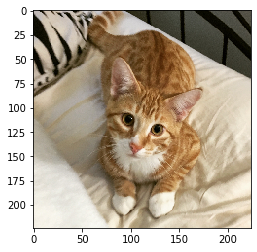

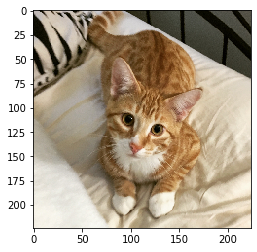

image batch size (1, 224, 224, 3)


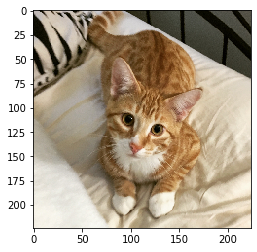

In [13]:
#load vgg16
vgg_model = vgg16.VGG16(weights = 'imagenet')

#load data
filename = 'cat.jpg'

original = load_img(filename, target_size = (224, 224))
plt.imshow(original)
plt.show()

numpy_image = img_to_array(original)
plt.imshow(np.uint(numpy_image))
plt.show()

image_batch = np.expand_dims(numpy_image, axis = 0)   #CNN은 무조건 4차원!
print('image batch size', image_batch.shape)
plt.imshow(np.uint8(image_batch[0]))


In [14]:
#preprocessing
processed_image = vgg16.preprocess_input(image_batch.copy())
predictions = vgg_model.predict(processed_image)
print(predictions.shape)
print(predictions)     #1000개 클래스에 대한 확률

(1, 1000)
[[8.31926883e-08 1.05695551e-06 7.08052585e-06 6.76434411e-06
  1.74739125e-06 1.09504333e-06 2.33493751e-07 1.53932558e-06
  3.13337637e-06 1.73684267e-08 2.29792661e-07 1.76711730e-08
  9.45173667e-07 1.68987455e-07 1.35002551e-08 5.93302161e-07
  7.95412518e-08 3.93653181e-07 7.06741119e-08 5.69162530e-08
  1.22974043e-07 6.62195873e-07 5.48804557e-08 1.81675944e-07
  9.08097320e-07 2.08923030e-08 4.87337282e-08 7.57056355e-08
  1.03455328e-07 2.73650159e-07 5.89085758e-08 6.67391689e-08
  4.41444712e-08 1.03198488e-06 7.36112554e-07 4.63556695e-08
  3.43891458e-07 3.07623145e-06 9.68011955e-06 2.02732826e-06
  5.97160522e-07 6.94081518e-06 7.06097410e-07 1.44315572e-06
  5.79386733e-06 4.26271470e-07 1.62846504e-06 1.90061041e-06
  2.31408954e-08 1.67725474e-07 1.34183131e-06 1.40536977e-05
  3.86972204e-07 1.44625773e-07 1.08961131e-05 8.94194656e-08
  9.96261861e-06 6.92012463e-07 4.08752157e-07 5.97783298e-07
  1.29793489e-05 8.28108477e-06 3.40585711e-06 1.27085048e-0

In [15]:
np.argmax(predictions)   #가장 확률 높은 클래스의 인덱스

282

인덱스까지는 출력했지만, 이게 도통 무슨 클래스를 지칭하는지 알 수 없다.

근데 이미 함수가 마련되어 있다.
- **`decode_predictions`** 메소드를 활용해서 분류 결과를 클래스 이름으로 디코딩할 수 있다.
    - top: 확률 상위 몇 개 클래스까지 볼건지

In [16]:
label_vgg = decode_predictions(predictions, top=10)
print(label_vgg)

[[('n02123159', 'tiger_cat', 0.2853994), ('n02124075', 'Egyptian_cat', 0.28331998), ('n02123045', 'tabby', 0.11448438), ('n04033995', 'quilt', 0.10585389), ('n02804414', 'bassinet', 0.037681397), ('n03125729', 'cradle', 0.025143798), ('n04265275', 'space_heater', 0.0246053), ('n03131574', 'crib', 0.010683239), ('n03938244', 'pillow', 0.007819731), ('n04040759', 'radiator', 0.007200494)]]


와 대박....

## 4-2. 다른 모델로도 해본다.

In [17]:
#Load the Inception_V3 model
inception_model = inception_v3.InceptionV3(weights='imagenet')

#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet')
 
#Load the MobileNet model
mobilenet_model = mobilenet.MobileNet(weights='imagenet')  

### 4-2-1. ResNet

In [18]:
processed_image = resnet50.preprocess_input(image_batch.copy())
predictions = resnet_model.predict(processed_image)
label_resnet = decode_predictions(predictions)
label_resnet

[[('n02123159', 'tiger_cat', 0.9054351),
  ('n02123045', 'tabby', 0.058966994),
  ('n02124075', 'Egyptian_cat', 0.03092894),
  ('n02127052', 'lynx', 0.0014053729),
  ('n04033995', 'quilt', 0.000954458)]]

### 4-2-1. MobileNet

In [19]:
processed_image = mobilenet.preprocess_input(image_batch.copy())
predictions = mobilenet_model.predict(processed_image)
label_mobilenet = decode_predictions(predictions)
label_mobilenet

[[('n02124075', 'Egyptian_cat', 0.39126283),
  ('n02123159', 'tiger_cat', 0.30310896),
  ('n02123045', 'tabby', 0.23901388),
  ('n03482405', 'hamper', 0.01634125),
  ('n02808304', 'bath_towel', 0.0054465253)]]

### 4-2-3. Inception_v3
- **이미지 사이즈** (299, 299)

In [20]:
filename = 'cat.jpg'
original = load_img(filename, target_size=(299, 299))   #이미지 크기!!!!
numpy_image = img_to_array(original)
image_batch = np.expand_dims(numpy_image, axis=0)

processed_image = inception_v3.preprocess_input(image_batch.copy())
predictions = inception_model.predict(processed_image)
label_inception = decode_predictions(predictions)
label_inception

[[('n02123159', 'tiger_cat', 0.7137169),
  ('n02123045', 'tabby', 0.16076781),
  ('n02124075', 'Egyptian_cat', 0.039307196),
  ('n03958227', 'plastic_bag', 0.014830568),
  ('n04033995', 'quilt', 0.011399656)]]

## 4-3. 모델별 결과 시각화

In [21]:
import cv2
img = cv2.imread("cat.jpg")
img = cv2.resize(img, (1000,1000))
cv2.putText(img, "VGG16: {}, {:.2f}".format(label_vgg[0][0][1], label_vgg[0][0][2]) , (350, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3)
cv2.putText(img, "MobileNet: {}, {:.2f}".format(label_mobilenet[0][0][1], label_mobilenet[0][0][2]) , (350, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3)
cv2.putText(img, "Inception: {}, {:.2f}".format(label_inception[0][0][1], label_inception[0][0][2]) , (350, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3)
cv2.putText(img, "ResNet50: {}, {:.2f}".format(label_resnet[0][0][1], label_resnet[0][0][2]) , (350, 145), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3)
cv2.imwrite("out.jpg", img)

True

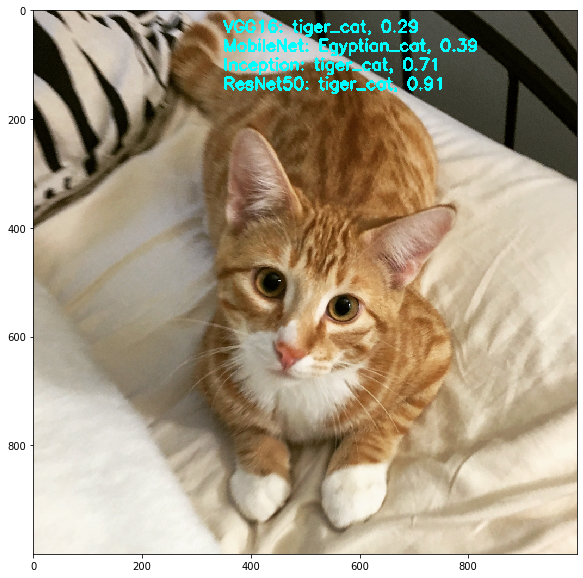

In [22]:
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

- MobileNet 성능이 가장 별로다.
- VGG16은 분류는 제대로 했지만 확률이 낮다. --> 이런 경우 좋은 분류라고 할 수 없다.
- ResNet 성능이 가장 좋다.

## 4-4. 다시 해보기: include_top = False

> 특징 추출기만 가져오는 것; 분류기는 빼고

- 뒤의 DNN은 빼고 Convolution layer만 가져오기 때문에 파라미터 수가 확 줄어든다. 

In [23]:
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet', include_top = False)


#Load the Inception_V3 model
inception_model = inception_v3.InceptionV3(weights='imagenet', include_top = False)


#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet', include_top = False)
 
#Load the MobileNet model
mobilenet_model = mobilenet.MobileNet(weights='imagenet', include_top = False)  

C:\Users\student\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
C:\Users\student\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [24]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

확실히 파라미터 수가 줄었다.
- 138,357,544 --> 14,714,688

# 5. 일반화

1. 모델 불러오기

2. 파일 불러오기 (flow_from_directory)

3. 모델 시행(예측)

4. 결과 출력

5. 시각화

## 5-1. 직접 해보기

In [26]:
#1. 모델 불러오기 (Inception은 타겟사이즈가 달라서 제외)
vgg_model = vgg16.VGG16(weights='imagenet')

resnet_model = resnet50.ResNet50(weights='imagenet')
 
mobilenet_model = mobilenet.MobileNet(weights='imagenet')  

#2. 파일 불러오기
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

DIR = './ex'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(DIR, target_size=(224, 224), class_mode = 'binary', shuffle = False)

Found 10 images belonging to 1 classes.


## 디렉토리 주의사항!

폴더 안에 바로 이미지를 넣으면 안됨

폴더1 안에 폴더2 안에 이미지를 넣어서 폴더1을 참조해야함
    - 그냥 그렇다
    - 폴더2 이름은 상관 없음

In [27]:
#3. 모델 시행(예측)
res_pred = resnet_model.predict_generator(test_generator)
vgg_pred = vgg_model.predict_generator(test_generator)
mobile_pred = mobilenet_model.predict_generator(test_generator)

In [28]:
#4. 결과 출력
for i in range(10):
    print(i+1, '\n',
        "Res:", decode_predictions(res_pred)[i][0][1:], '\n',
         "Vgg:", decode_predictions(vgg_pred)[i][0][1:], '\n',
         "Mobile:", decode_predictions(mobile_pred)[i][0][1:], '\n',
         '------------------------------------------')

1 
 Res: ('nematode', 0.117708944) 
 Vgg: ('mosquito_net', 0.27763364) 
 Mobile: ('silky_terrier', 0.7110144) 
 ------------------------------------------
2 
 Res: ('nematode', 0.11336881) 
 Vgg: ('mosquito_net', 0.17872581) 
 Mobile: ('Chesapeake_Bay_retriever', 0.98456347) 
 ------------------------------------------
3 
 Res: ('nematode', 0.11889981) 
 Vgg: ('mosquito_net', 0.13802896) 
 Mobile: ('Japanese_spaniel', 0.25326312) 
 ------------------------------------------
4 
 Res: ('nematode', 0.11667341) 
 Vgg: ('mosquito_net', 0.10405987) 
 Mobile: ('Shetland_sheepdog', 0.35382184) 
 ------------------------------------------
5 
 Res: ('nematode', 0.1249168) 
 Vgg: ('mosquito_net', 0.16432773) 
 Mobile: ('English_foxhound', 0.17458458) 
 ------------------------------------------
6 
 Res: ('nematode', 0.119310625) 
 Vgg: ('mosquito_net', 0.19264774) 
 Mobile: ('orangutan', 0.8721159) 
 ------------------------------------------
7 
 Res: ('nematode', 0.1169737) 
 Vgg: ('mosquito_net

### 5-1-1. 이렇게 하면 안되는 이유

#3. 에서 predict_generator가 3회 호출되면서 test_generator가 서로 다른 이터레이션으로 돌아가기 때문

(predict_generator가 호출될 때마다 `test_generator.next`가 내부적으로 실행되기 때문이다.)
- Vgg에서 이터레이션 1
- ResNet에서 이터레이션 2
- MobileNet에서 이터레이션 3
이 돌아가기 때문에 서로 다른 데이터에 대해서 연산이 이루어지고 있을 수 있음

--> 따라서 generator의 이터레이션을 고정해주기 위해서 `test_generator.next()`를 **변수로 받아서** 그 변수로 이후 작업을 진행하는 것이 좋다.

## 5-2. 솔루션

In [33]:
# 솔루션

#데이터 불러오기
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
                                'ex', target_size = (224, 224),
                                class_mode = 'binary', shuffle = False)

X, T = test_generator.next()   #X: 이미지, T: 레이블

#모델 시행 및 디코딩
decode_vgg = decode_predictions(vgg_model.predict(vgg16.preprocess_input(X.copy())))
decode_resnet = decode_predictions(resnet_model.predict(resnet50.preprocess_input(X.copy())))
decode_mobilenet = decode_predictions(mobilenet_model.predict(mobilenet.preprocess_input(X.copy())))

#결과 출력
for i in range(X.shape[0]):
    img = cv2.resize(X[i], (1000, 1000))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.putText(img, f"VGG16: {decode_vgg[i][0][1]}", (50, 50),
               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
    cv2.putText(img, f"RESNET: {decode_resnet[i][0][1]}", (50, 75),
               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
    cv2.putText(img, f"MOBILENET: {decode_mobilenet[i][0][1]}", (50, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
    cv2.imwrite(f"ship{i+1}.jpg", img)

Found 10 images belonging to 1 classes.


# 6. 전이학습(과일예제)

- Vgg를 top 제외하고 불러와서 뒤에 DNN을 더해서 쓸 거다.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img

In [35]:
train_dir = './clean-dataset/train'
validation_dir = './clean-dataset/validation'
image_size = 224

## 6-1. 전체 freezing

In [41]:
from keras.applications import VGG16

#Load the VGG model: CNN 파트만 가져온다(include_top = False)
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze ALL the layers: 불러온 vgg 모델에서 학습이 이루어지지 않도록 고정
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


from keras import models
from keras import layers
from keras import optimizers

# Create the model: 모델 생성
model = models.Sequential()

# Add the vgg convolutional base model: 먼저 불러온 vgg 모델 끼워넣기
model.add(vgg_conv)

# Add new layers: DNN 파트는 알아서 적절히 추가
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<keras.engine.input_layer.InputLayer object at 0x000002E35BAFDAC8> False
<keras.layers.convolutional.Conv2D object at 0x000002E35BAFDBC8> False
<keras.layers.convolutional.Conv2D object at 0x000002E31A25B8C8> False
<keras.layers.pooling.MaxPooling2D object at 0x000002E33AE961C8> False
<keras.layers.convolutional.Conv2D object at 0x000002E33AE96E08> False
<keras.layers.convolutional.Conv2D object at 0x000002E35BAE5988> False
<keras.layers.pooling.MaxPooling2D object at 0x000002E35BAE7688> False
<keras.layers.convolutional.Conv2D object at 0x000002E35BAEB308> False
<keras.layers.convolutional.Conv2D object at 0x000002E35BAEC948> False
<keras.layers.convolutional.Conv2D object at 0x000002E35BAF2648> False
<keras.layers.pooling.MaxPooling2D object at 0x000002E35BAF4CC8> False
<keras.layers.convolutional.Conv2D object at 0x000002E35BAF7948> False
<keras.layers.convolutional.Conv2D object at 0x000002E35BAFF4C8> False
<keras.layers.convolutional.Conv2D object at 0x000002E35BAFFFC8> False
<ker

### 6-1-1. w/o Augmentation

In [42]:
# No Data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 10
val_batchsize = 10

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [43]:
# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/5
60/60 [==============================] - 488s 8s/step - loss: 3.4799 - accuracy: 0.6550 - val_loss: 0.2322 - val_accuracy: 0.8933
Epoch 2/5
60/60 [==============================] - 490s 8s/step - loss: 0.5670 - accuracy: 0.8800 - val_loss: 2.1830 - val_accuracy: 0.7933
Epoch 3/5
60/60 [==============================] - 489s 8s/step - loss: 0.2182 - accuracy: 0.9300 - val_loss: 0.0362 - val_accuracy: 0.8600
Epoch 4/5
60/60 [==============================] - 490s 8s/step - loss: 0.1068 - accuracy: 0.9583 - val_loss: 0.0172 - val_accuracy: 0.9067
Epoch 5/5
60/60 [==============================] - 494s 8s/step - loss: 0.0451 - accuracy: 0.9867 - val_loss: 0.0035 - val_accuracy: 0.9000


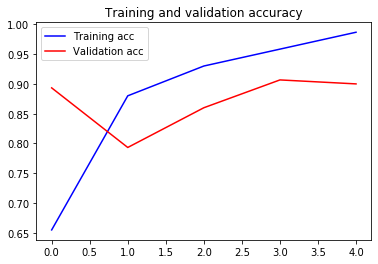

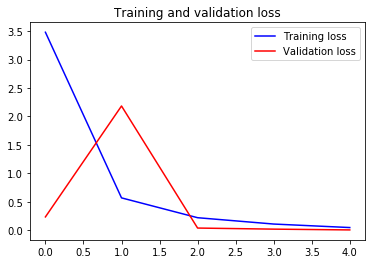

In [44]:
# Save the Model
model.save('all_freezed_wa.h5')

# Plot the accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 6-1-2. w/ Augmentation
- 위에서 했던 거랑 같은 조건으로 이 모델(Vgg + DNN) 돌려보기

In [45]:
# Data augmentation 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 10
val_batchsize = 10

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [46]:
# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/5
60/60 [==============================] - 488s 8s/step - loss: 0.7797 - accuracy: 0.8367 - val_loss: 0.0256 - val_accuracy: 0.8933
Epoch 2/5
60/60 [==============================] - 489s 8s/step - loss: 0.4490 - accuracy: 0.8817 - val_loss: 0.4426 - val_accuracy: 0.8133
Epoch 3/5
60/60 [==============================] - 481s 8s/step - loss: 0.4144 - accuracy: 0.8933 - val_loss: 0.0084 - val_accuracy: 0.9067
Epoch 4/5
60/60 [==============================] - 488s 8s/step - loss: 0.2725 - accuracy: 0.9183 - val_loss: 0.2758 - val_accuracy: 0.8533
Epoch 5/5
60/60 [==============================] - 482s 8s/step - loss: 0.1606 - accuracy: 0.9450 - val_loss: 0.0040 - val_accuracy: 0.9000


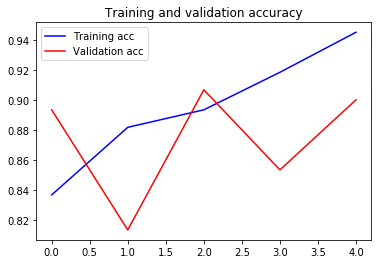

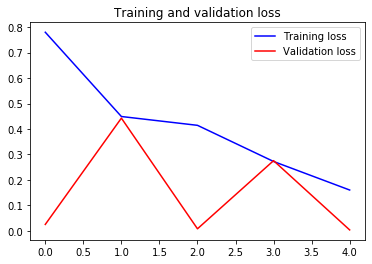

In [47]:
# Save the Model
model.save('all_freezed.h5')

# Plot the accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 6-2. Pretrained CNN 몇 레이어 살리기
- Pretrained CNN은 보통 다음과 같이 구성된다.
    - low-level 특징을 추출하는 레이어들이 가장 먼저 있고
    - 중간 단계,
    - high-level 특징을 추출하는 레이어들이 마지막에 있다.
        - high-level 레이어에서는 maxpooling을 많이 하면서 특징을 크게크게 본다
        - => 모델의 기본적인 특징 추출 기능은 그대로 가져가면서 **fine-tuning**이 가능하다는 뜻!
        
- 따라서 Pretrained CNN을 조금 튜닝해서 쓰고 싶다면, 마지막 단계에 있는 **high-level 레이어들**을 살리면 된다.

In [48]:
from keras.applications import VGG16

#Load the VGG model: CNN 파트만 가져온다(include_top = False)
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freezing + Leaving some layers: filter 레벨도 수정
for layer in vgg_conv.layers[:4]:    # 마지막 4개 층은 fine-tuning을 위해 살렸다.
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


from keras import models
from keras import layers
from keras import optimizers

# Create the model: 모델 생성
model = models.Sequential()

# Add the vgg convolutional base model: 먼저 불러온 vgg 모델 끼워넣기
model.add(vgg_conv)

# Add new layers: DNN 파트는 알아서 적절히 추가
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))     #여기 줄였다
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<keras.engine.input_layer.InputLayer object at 0x000002E36840F788> False
<keras.layers.convolutional.Conv2D object at 0x000002E36840FA08> False
<keras.layers.convolutional.Conv2D object at 0x000002E36840FD48> False
<keras.layers.pooling.MaxPooling2D object at 0x000002E368475A08> False
<keras.layers.convolutional.Conv2D object at 0x000002E368478748> True
<keras.layers.convolutional.Conv2D object at 0x000002E368381648> True
<keras.layers.pooling.MaxPooling2D object at 0x000002E3683F3FC8> True
<keras.layers.convolutional.Conv2D object at 0x000002E3683BB808> True
<keras.layers.convolutional.Conv2D object at 0x000002E368401B08> True
<keras.layers.convolutional.Conv2D object at 0x000002E3683F2F08> True
<keras.layers.pooling.MaxPooling2D object at 0x000002E368466A08> True
<keras.layers.convolutional.Conv2D object at 0x000002E368422408> True
<keras.layers.convolutional.Conv2D object at 0x000002E368443F08> True
<keras.layers.convolutional.Conv2D object at 0x000002E36844CFC8> True
<keras.layers.

### 6-2-1. w/ Augmentation
- CNN fine-tuning + augmentation이 결합되면 성능이 좋아질까?

In [49]:
# Data augmentation 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 10
val_batchsize = 10

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [50]:
# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/5
60/60 [==============================] - 874s 15s/step - loss: 1.6829 - accuracy: 0.3083 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 2/5
60/60 [==============================] - 868s 14s/step - loss: 1.0988 - accuracy: 0.3317 - val_loss: 1.0973 - val_accuracy: 0.3333
Epoch 3/5


KeyboardInterrupt: 

In [ ]:
# Save the Model
model.save('fine_tuned.h5')

# Plot the accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 부록) 정규화의 중요성

- 데이터 정규화는 꼭 한다고 생각하면 된다.
    - 맡길 생각 말고
    - 데이터가 비교적 단순한 데에도 학습이 이루어지지 않는다면 --> 정규화를 까먹지 않았나 확인
- 이미지 처리는 간편하다. --> 255로 나눠주면 되기 때문
- 다른 데이터는 일반적으로 min, max값으로 정규화하면 된다.
- 정규화는 **dimension별**로!
    - 서로 다른 min, max를 가진 feature들을 몽땅 묶어서 전체 min, max로 정규화하면 절대 학습이 이루어지지 않는다.